Let's now work on the model to try and predict the damage level of each building. Let's start by importing the necessary libraries and the dataset containing the one-hot signatures created in the previous notebook.

In [60]:
import torch
import pandas as pd
import numpy as np

from IPython.display import clear_output

In [2]:
# dataframe = pd.read_csv('signature_dataframe.csv')
dataframe = pd.read_pickle('signature_dataframe.pkl')
dataframe.head()

,x,y
0,"[-0.8674214516922528, 0.5968959280707078, 1, 0...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[-0.7894931324262333, 1.6023856802166563, 0, 1...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[-0.664418864464821, 0.4405339408980041, 1, 0,...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[-0.21363849853229364, 0.19104651928789274, 0,...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[-0.21115149773491346, 0.1691897795630536, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullyConnectedNN(nn.Module):
    def __init__(self, input_len, output_len, hidden_dim, depth):
        super(FullyConnectedNN, self).__init__()
        self.input_len = input_len
        self.output_len = output_len
        self.depth = depth
        self.hidden_dim = hidden_dim
        self.fc_layers = nn.Sequential()
        
        for i in range(depth):
            in_features = self.input_len if i == 0 else self.hidden_dim
            self.fc_layers.add_module(f"fc{i}", nn.Linear(in_features, self.hidden_dim))
            self.fc_layers.add_module(f"relu{i}", nn.ReLU())
        
        self.classifier = nn.Sequential(nn.Linear(self.hidden_dim, self.output_len), nn.Softmax(dim=1))
        # print number of parameters
        print(f"Number of parameters: {sum(p.numel() for p in self.parameters() if p.requires_grad)}")
        
    def forward(self, x):
        x = self.fc_layers(x.view(-1, self.input_len))
        x = self.classifier(x)
        return x


In [17]:
dataframe['y'].iloc[[0,1]]

0    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: y, dtype: object

In [73]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Get the label for the current sample
        label = torch.Tensor(self.dataframe['y'].iloc[idx])
        
        # Get the input for the current sample
        input = torch.Tensor(self.dataframe['x'].iloc[idx])
        
        return input, label
    def train_test_split(self, train_size=0.8):
        train_size = int(train_size * len(self))
        test_size = len(self) - train_size
        return torch.utils.data.random_split(self, [train_size, test_size])



class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=0.05, logits=True, reduction='elementwise_mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'elementwise_mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else: 
            return F_loss

In [74]:
dataset = CustomDataset(dataframe)
train_dataset, test_dataset = dataset.train_test_split()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=3200, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=3200, shuffle=True)

In [75]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from sklearn.metrics import classification_report

def train(model, train_dataloader, test_dataloader, loss_fn, optimizer, num_epochs, log_interval=10):
    model.to(DEVICE)
    train_losses = []
    test_losses = []
    test_scores = []

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0

        model.train()
        for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            test_loss = 0
            y_true = []
            y_pred = []
            for data in test_dataloader:
                inputs, labels = data
                
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                test_loss += loss.item()
                
                labels = torch.argmax(labels, dim=1).view(-1, 1)
                predicted = torch.argmax(outputs.data, 1).view(-1, 1)
                y_true.extend(labels.cpu().numpy().tolist())
                y_pred.extend(predicted.cpu().numpy().tolist())

        test_loss /= len(test_dataloader)
        test_losses.append(test_loss)
        test_score = classification_report(y_true, y_pred, zero_division=0)
        test_scores.append(test_score)

        if (epoch + 1) % log_interval == 0:
            # clear output
            clear_output(wait=True)
            
            fig, ax = plt.subplots()
            ax.plot(train_losses, label='Training Loss')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.legend()

            fig, ax = plt.subplots()
            ax.plot(test_losses, label='Testing Loss')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.legend()

            plt.show()
        
        print(f"Epoch {epoch + 1}/{num_epochs}: Training Loss: {train_loss:.4f} Test Loss: {test_loss:.4f} Test Score:\n {test_score} ")



In [76]:
model = FullyConnectedNN(input_len=len(dataset[0][0]), output_len=len(dataset[0][1]), hidden_dim=100, depth=4)

Number of parameters: 40826


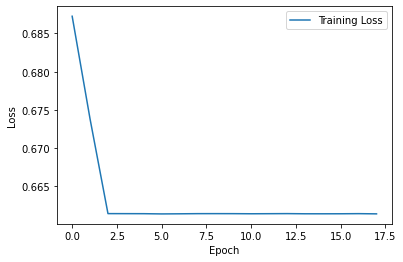

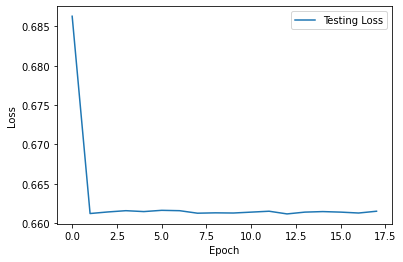

 18%|█▊        | 18/100 [01:30<06:01,  4.40s/it]

Epoch 18/100: Training Loss: 0.6614 Test Loss: 0.6615 Test Score:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91     10967
           1       0.00      0.00      0.00       210
           2       0.00      0.00      0.00       193
           3       0.00      0.00      0.00       106
           4       0.00      0.00      0.00       808
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00       160
           7       0.00      0.00      0.00       151
           8       0.00      0.00      0.00       116
           9       0.00      0.00      0.00       295
          10       0.00      0.00      0.00        56
          11       0.00      0.00      0.00        14
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         1
          16  

 19%|█▉        | 19/100 [01:34<05:52,  4.36s/it]

Epoch 19/100: Training Loss: 0.6614 Test Loss: 0.6614 Test Score:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91     10967
           1       0.00      0.00      0.00       210
           2       0.00      0.00      0.00       193
           3       0.00      0.00      0.00       106
           4       0.00      0.00      0.00       808
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00       160
           7       0.00      0.00      0.00       151
           8       0.00      0.00      0.00       116
           9       0.00      0.00      0.00       295
          10       0.00      0.00      0.00        56
          11       0.00      0.00      0.00        14
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         1
          16  

In [77]:
train(model, train_loader, test_loader, FocalLoss(), optim.Adam(model.parameters(), lr=0.001), num_epochs=100, log_interval=2)